In [1]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob
import pandas as pd

In [2]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data


import matplotlib
from scipy import interpolate
from scipy.interpolate import interp1d
def getcolor(vrange,cm=plt.cm.get_cmap('viridis')):
    cmap = cm
    norm = matplotlib.colors.Normalize(vmin=min(vrange[:-1]), vmax=max(vrange[:-1]))
    return [cmap(norm(i)) for i in vrange]

In [3]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]


In [ ]:
from os.path import exists

cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('plasma',20)

Rbirth_switch = True

for i in range(len(sims)):
    if sims[i]=='g1.12e12_3x9':
        continue
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    agepickle = readsimdata(simsnames[i],True, 15, 5, disk=True)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
    count = 0
            
    for j in trange(len(allages_rs)):
        #print('reading ',snaplookup[sortage[j]])
        if exists(snaplookup[sortage[j]]+'.pkl'):
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            if len(this_snap)==0:
                print('no stars in this snap!')
                continue
        else:
            s = pb.load(snaplookup[sortage[j]])
            h=s.halos()
            try:
                pb.analysis.angmom.faceon(h[1])
            except:
                print('no halo!')
                continue
            s.physical_units()
            sim = h[1]

            stars = sim.s
            if len(stars)==0:
                print('no stars!')
                continue
            
            try:
                stars['iord']
            except:
                print('no IDs!')
                continue
            this_snap = pd.DataFrame({k:stars[k] for k in cols})
            this_snap = pd.merge(this_snap, agepickle[['iord', 'age', 'feh', 'Rbir','zbir']], left_on='iord', right_on='iord', how='inner')
            this_snap.to_pickle(snaplookup[sortage[j]]+'.pkl')
        
        plt.figure(figsize=(10,8))
        plt.title(simsnames[i]+'; Cosmic Time = %.3f'%(allages_rs[j])+' Gyr', fontsize=25)
        if Rbirth_switch:
            plt.hexbin(this_snap['age'], this_snap['Rbir'], C = this_snap['r']-this_snap['Rbir'],
                   extent = (0,14,0,15), gridsize=40, vmin=0, vmax=4, cmap=cmap, reduce_C_function = np.std, mincnt = 20)
        else:
            plt.hexbin(this_snap['age'], this_snap['r'], C = this_snap['r']-this_snap['Rbir'],
                   extent = (0,14,0,15), gridsize=40, vmin=0, vmax=4, cmap=cmap, reduce_C_function = np.std, mincnt = 20)
        plt.xlabel('Age [Gyr]')
        if Rbirth_switch:
            plt.ylabel('$R_{bir}$')
        else:
            plt.ylabel('Current Radius')
        cb = plt.colorbar()
        cb.set_label('$σ_{R-R_{bir}}$ [kpc]')
        plt.tight_layout()
        if Rbirth_switch:
            plt.savefig('RM/'+simsnames[i]+'/'+str(count)+'_Rbir.png')
        else:
            plt.savefig('RM/'+simsnames[i]+'/'+str(count)+'.png')
        plt.xlim([0,14])
        plt.ylim([0,15])
        count = count+1
        plt.close()

In [5]:
def get_dR(df1, df2, rbins=np.linspace(0,15,40)):
    df = pd.merge(df1, df2, left_on='iord', right_on='iord', how='inner')
    if len(df)==0:
        return (rbins[:-1]+rbins[1:])/2, np.zeros(len(rbins)-1)*np.nan
    df['dR'] = df['r_y'] - df['r_x']
    df = df.dropna(subset=['dR']).reset_index(drop=True)
    dr_std = np.zeros(len(rbins)-1)*np.nan
    for i in range(len(rbins)-1):
        df_bin = df.loc[(df['r_y']>rbins[i])&(df['r_y']<rbins[i+1])].reset_index(drop=True)
        if len(df_bin) < 10:
            continue
        dr_std[i] = np.std(df_bin['dR'])
    return (rbins[:-1]+rbins[1:])/2, dr_std
    

g7.55e11_3x9


  4%|▍         | 5/127 [00:00<00:03, 38.95it/s]

no snap!


100%|██████████| 127/127 [01:59<00:00,  1.06it/s]


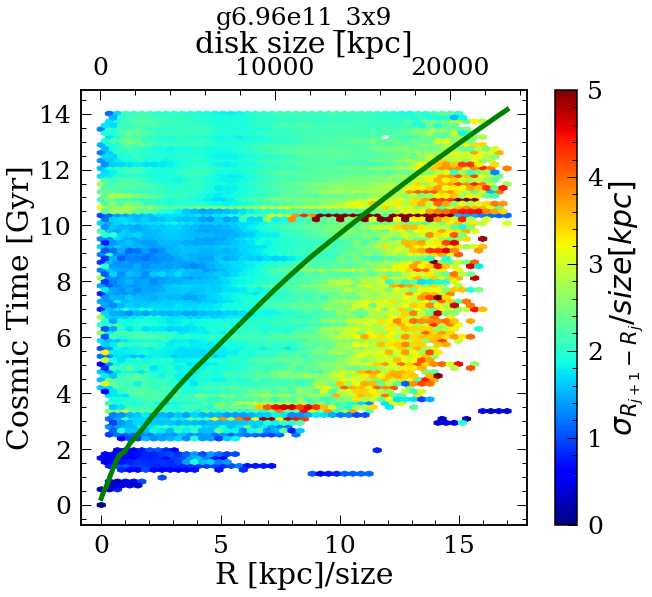

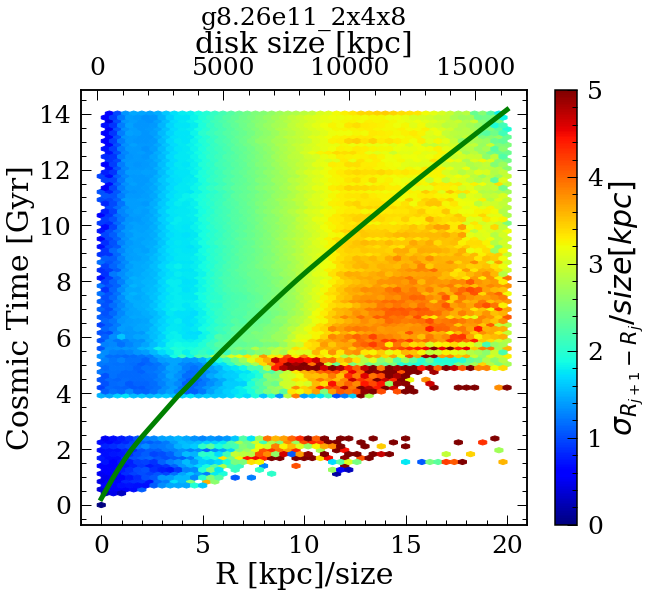

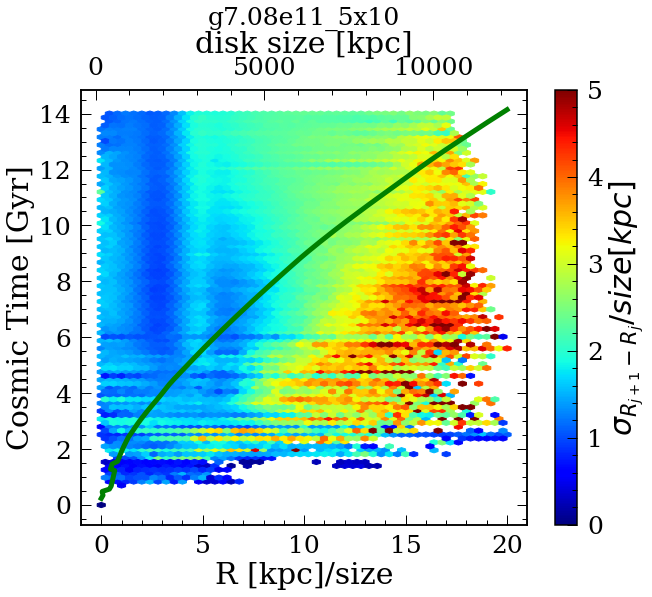

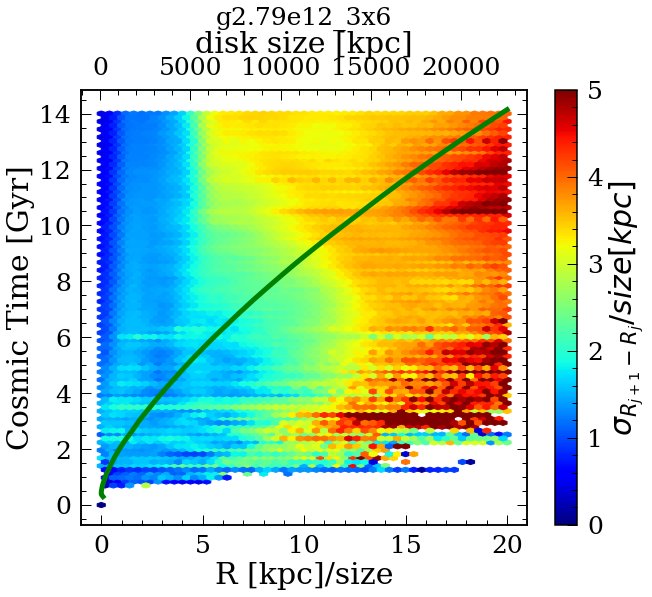

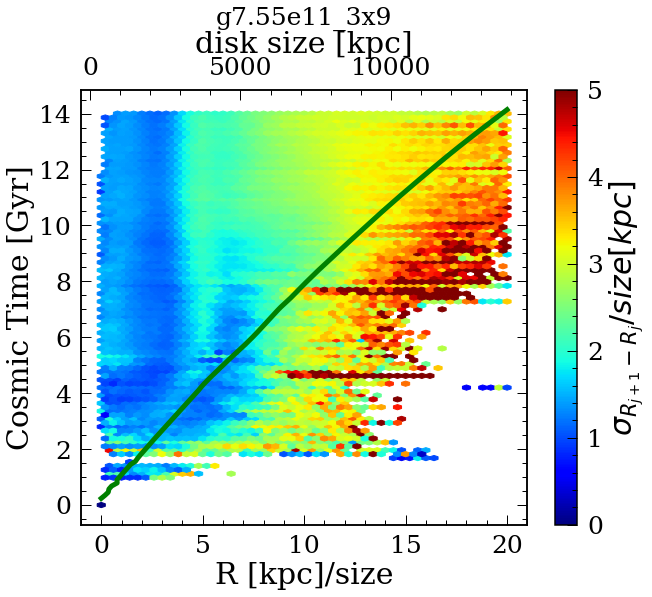

In [7]:
from os.path import exists
ext = [17,20,20,20,20]
cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('jet')
count_x = 0
for i in range(len(sims)):
    clear_output(wait=True)
    if sims[i]=='g1.12e12_3x9':
        continue
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    agepickle = readsimdata(simsnames[i],True, 30, 5)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
    count = 0
    
    # get disk size
    name = ''
    
    for k in sims[i].split('_')[0].split('.'):
        name = name+k
    if name == 'g112e12':
        continue
        
    df = pd.read_pickle('ISM_slope_'+name+'.pkl')
    
    disksize = df['half_mass_l2'].values

    rbins=np.linspace(0,20,80)
    alldrs = np.zeros((len(allages_rs)-1, len(rbins)-1))
    rbin = np.zeros((len(allages_rs)-1, len(rbins)-1))
    times = np.zeros((len(allages_rs)-1, len(rbins)-1))
    
    for j in trange(len(allages_rs)-1):
        try:
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            next_snap = pd.read_pickle(snaplookup[sortage[j+1]]+'.pkl')
            this_snap['age'], next_snap['age']
        except:
            print('no snap!')
            continue

        rbin[j,:], alldrs[j,:] = get_dR(this_snap, next_snap, rbins=rbins)
        rbin[j,:], alldrs[j,:] = rbin[j,:], alldrs[j,:]
        #alldrs[j,:] = (alldrs-np.median(pd.Series(alldrs[j,:]).dropna()))/np.std(pd.Series(alldrs[j,:]).dropna())
        #rbin[j,:] = (rbin-np.median(pd.Series(rbin[j,:]).dropna()))/np.std(pd.Series(rbin[j,:]).dropna())
        times[j,:] = allages_rs[j+1]*np.ones(len(rbin[j,:]))
    rbin, alldrs, times = rbin.flatten(), alldrs.flatten(), times.flatten()
    plt.figure(figsize=(10,8))
    plt.hexbin(rbin, times, C = alldrs, extent=(0,ext[count_x],0,14), gridsize=(50, 50),vmin=0,vmax=5,cmap=cmap)
    cb = plt.colorbar()
    cb.set_label('$σ_{R_{j+1}-R_{j}}/size [kpc]$')
    plt.ylabel('Cosmic Time [Gyr]')
    plt.xlabel('R [kpc]/size')
    plt.title(sims[i], fontsize=25)
    plt.twiny()
    plt.plot(disksize, df['time'], 'g-', linewidth=5)
    plt.xlabel('disk size [kpc]')
    plt.plot()
    count_x = count_x+1
        
        

g6.96e11_3x9


  0%|          | 0/128 [00:00<?, ?it/s]

no snap!


100%|██████████| 128/128 [00:41<00:00,  3.11it/s]


g8.26e11_2x4x8


  0%|          | 0/180 [00:00<?, ?it/s]

no snap!
no snap!


 18%|█▊        | 33/180 [00:09<00:40,  3.62it/s]

no snap!


100%|██████████| 180/180 [02:41<00:00,  1.12it/s]


g7.08e11_5x10


  0%|          | 0/160 [00:00<?, ?it/s]

no snap!


  1%|▏         | 2/160 [00:00<00:39,  4.01it/s]

no snap!


100%|██████████| 160/160 [02:28<00:00,  1.08it/s]


g2.79e12_3x6


  0%|          | 0/229 [00:00<?, ?it/s]

no snap!
no snap!
no snap!


100%|██████████| 229/229 [06:24<00:00,  1.68s/it]


g7.55e11_3x9


  0%|          | 0/128 [00:00<?, ?it/s]

no snap!


100%|██████████| 128/128 [01:25<00:00,  1.49it/s]


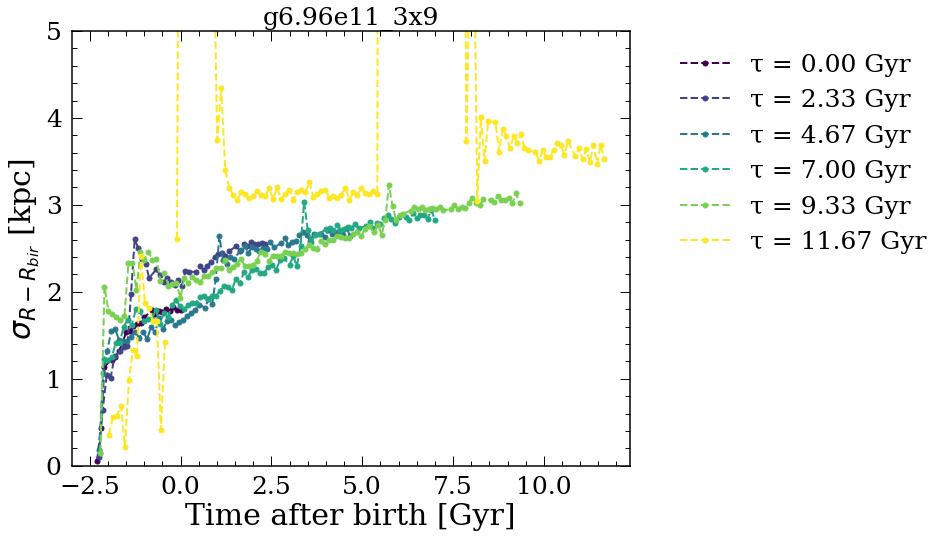

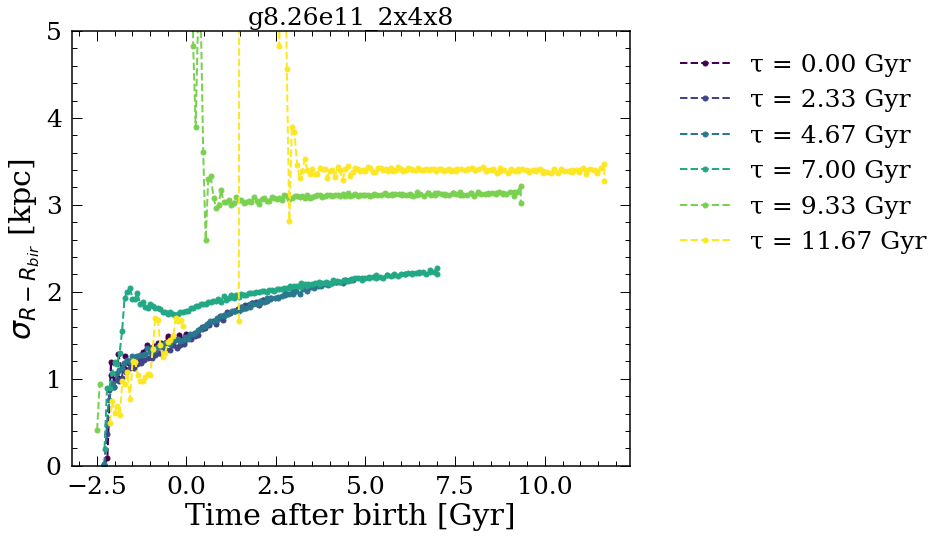

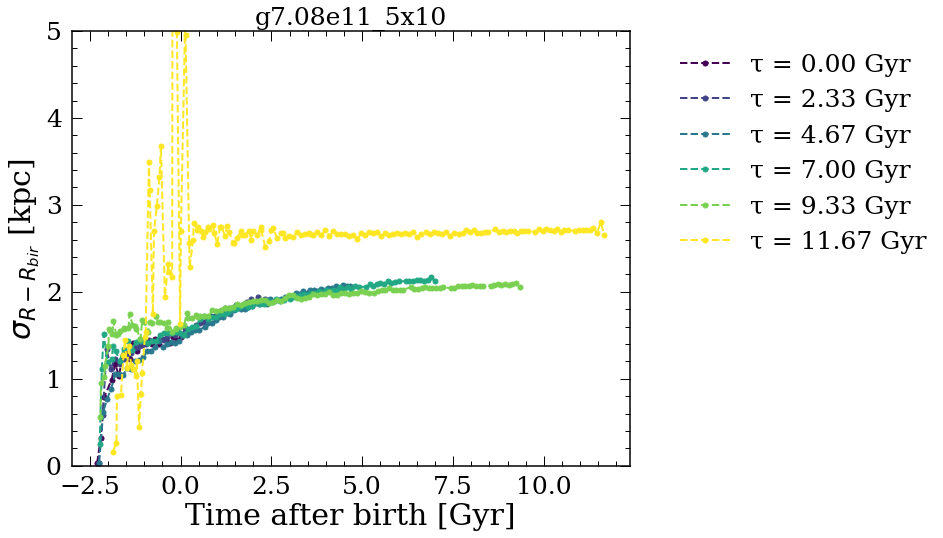

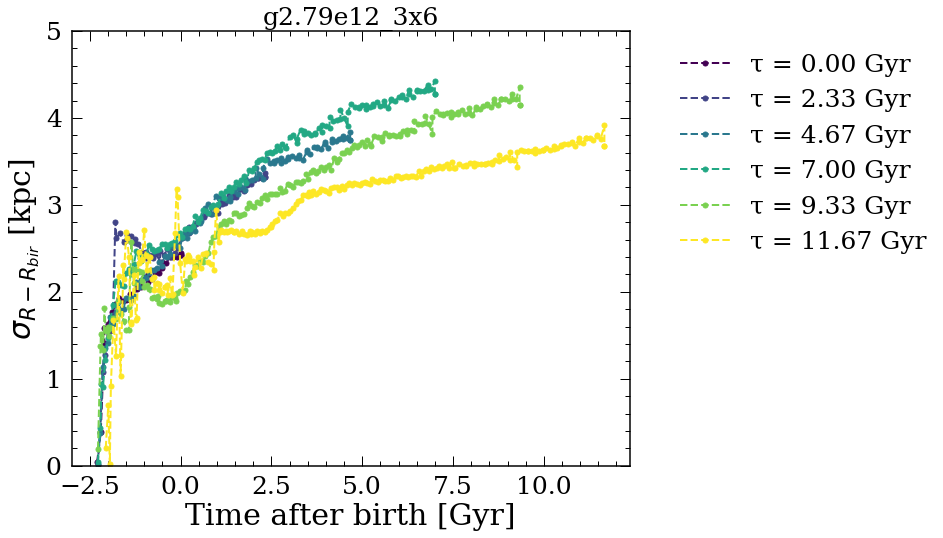

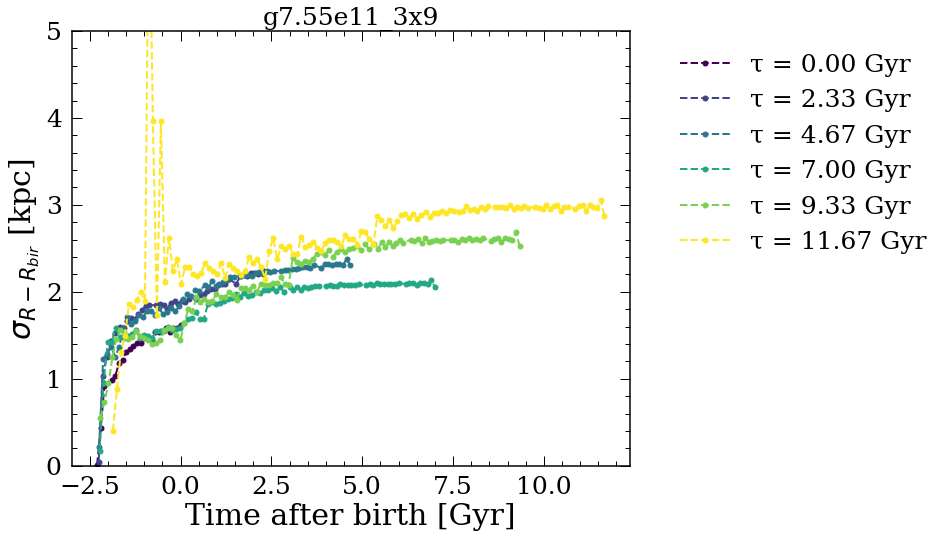

In [50]:
from os.path import exists
ext = [17,20,20,20,20]
cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('binary')
count_x = 0
for i in range(len(sims)):
    clear_output(wait=True)
    if sims[i]=='g1.12e12_3x9':
        continue
    print(sims[i])
    simname = sims[i]
    
    allsnaps = glob.glob(sims[i]+'/*.?????')
    
    agepickle = readsimdata(simsnames[i],True, 15, 3, disk=True)
    
    allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
    snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

    sortage = sorted(allsnaps_time)
    redshifts = np.zeros(len(sortage))
    allages_rs = np.zeros(len(redshifts))
    for j in trange(len(sortage)):
        s = pb.load(snaplookup[sortage[j]])
        h = s.properties['h']
        ages = float(str(s.properties['time']).split(' ')[0])
        allages_rs[j] = ages
    count = 0
    
    
    ########################################
    agebins = np.linspace(0,14,7)
    whatagebin = np.nan*np.ones(len(agepickle))
    for j in range(len(agebins)-1):
        m = ((agepickle['age']>agebins[j])&(agepickle['age']<agebins[j+1]))
        whatagebin[m] = j
    agepickle['binNumb'] = whatagebin
    
    alldrs = np.nan*np.ones((len(agebins)-1, len(allages_rs)))
    for j in trange(len(allages_rs)):
        try:
            this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
            this_snap['age']
        except:
            print('no snap!')
            continue
        this_snap = pd.merge(this_snap[['iord','r']], agepickle[['iord','binNumb','Rbir']], 
                             left_on='iord', right_on='iord', how='inner')

        this_snap['dR'] = this_snap['r']-this_snap['Rbir']
        for k in this_snap['binNumb'].unique():
            m_eachbin = (this_snap['binNumb']==k)
            if sum(m_eachbin)==0:
                continue
            alldrs[int(k), j] = np.std(this_snap[m_eachbin]['dR'])
    allcolors = getcolor(agebins)
    plt.figure(figsize=(10,8))
    for k in range(len(agebins)-1):
        PCM=plt.plot(allages_rs-14.1+agebins[k], alldrs[k,:], '--o',c=allcolors[k],markersize=5,
                     label='τ = %.2f Gyr'%agebins[k])
    #cb.set_label('Age [Gyr]')
    plt.xlabel('Time after birth [Gyr]')
    plt.ylabel('$σ_{R-R_{bir}}$ [kpc]')
    plt.title(sims[i], fontsize=25)
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.ylim([0,5])
    #plt.yscale('log')
        
        

In [62]:
from os.path import exists
ext = [17,20,20,20,20]
cols = ['iord','r','z','x','y']
cmap = plt.cm.get_cmap('binary')
count_x = 0

i=-1
print(sims[i])
simname = sims[i]

allsnaps = glob.glob(sims[i]+'/*.?????')

agepickle = readsimdata(simsnames[i],True, 15, 3, disk=True)

allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

sortage = sorted(allsnaps_time)
redshifts = np.zeros(len(sortage))
allages_rs = np.zeros(len(redshifts))
for j in trange(len(sortage)):
    s = pb.load(snaplookup[sortage[j]])
    h = s.properties['h']
    ages = float(str(s.properties['time']).split(' ')[0])
    allages_rs[j] = ages
count = 0

g7.55e11_3x9


100%|██████████| 128/128 [00:23<00:00,  5.50it/s]


  0%|          | 0/229 [00:00<?, ?it/s]

no snap!
no snap!
no snap!


100%|██████████| 229/229 [07:25<00:00,  1.94s/it]
/tmp/ipykernel_1129574/3652633228.py:29: RuntimeWarning: divide by zero encountered in log
  PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
/tmp/ipykernel_1129574/3652633228.py:29: RuntimeWarning: invalid value encountered in log
  PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
/tmp/ipykernel_1129574/3652633228.py:32: RuntimeWarning: divide by zero encountered in log
  p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
/tmp/ipykernel_1129574/3652633228.py:32: RuntimeWarning: invalid value encountered in log
  p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
/tmp/ipykernel_1129574/3652633228.py:33: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), p(np.log(allages_rs-14.1+agebins[k]+2.5)), '-', c=allcolor

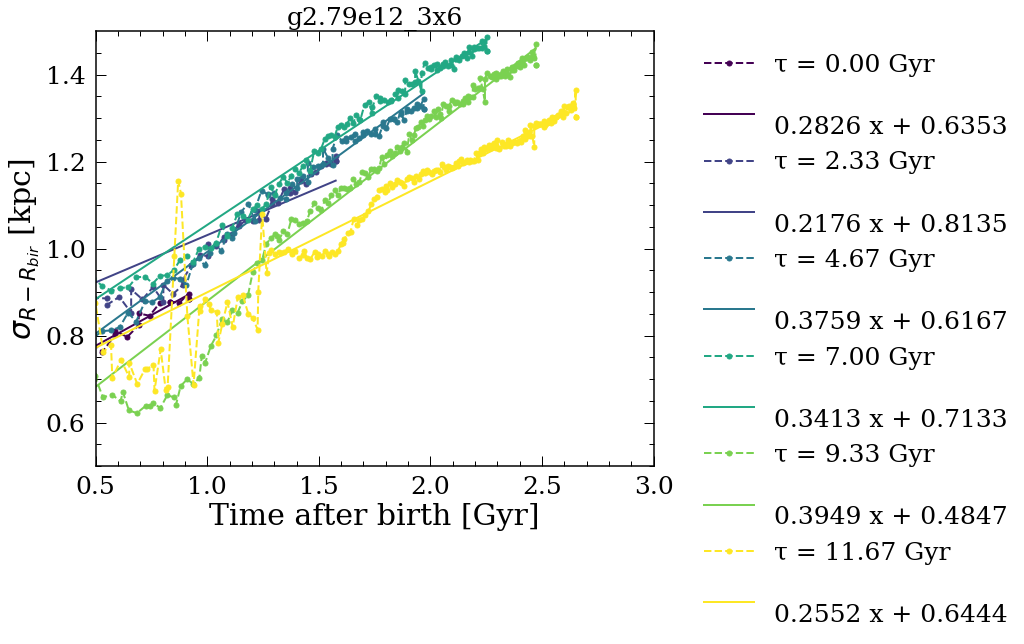

In [61]:
########################################
agebins = np.linspace(0,14,7)
whatagebin = np.nan*np.ones(len(agepickle))
for j in range(len(agebins)-1):
    m = ((agepickle['age']>agebins[j])&(agepickle['age']<agebins[j+1]))
    whatagebin[m] = j
agepickle['binNumb'] = whatagebin

alldrs = np.nan*np.ones((len(agebins)-1, len(allages_rs)))
for j in trange(len(allages_rs)):
    try:
        this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
        this_snap['age']
    except:
        print('no snap!')
        continue
    this_snap = pd.merge(this_snap[['iord','r']], agepickle[['iord','binNumb','Rbir']], 
                         left_on='iord', right_on='iord', how='inner')

    this_snap['dR'] = this_snap['r']-this_snap['Rbir']
    for k in this_snap['binNumb'].unique():
        m_eachbin = (this_snap['binNumb']==k)
        if sum(m_eachbin)==0:
            continue
        alldrs[int(k), j] = np.std(this_snap[m_eachbin]['dR'])
allcolors = getcolor(agebins)
plt.figure(figsize=(10,8))
for k in range(len(agebins)-1):
    PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
                 label='τ = %.2f Gyr'%agebins[k])
    m = (allages_rs-14.1+agebins[k]+2.5>1)
    p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
    plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), p(np.log(allages_rs-14.1+agebins[k]+2.5)), '-', c=allcolors[k], label=str(p))
plt.legend()
    
#cb.set_label('Age [Gyr]')
plt.xlabel('Time after birth [Gyr]')
plt.ylabel('$σ_{R-R_{bir}}$ [kpc]')
plt.title(sims[i], fontsize=25)
plt.legend(bbox_to_anchor=(1.05,1))
plt.ylim([0.5,1.5])
plt.xlim([0.5,3])

plt.legend(bbox_to_anchor=(1.05,1))
#plt.yscale('log')
        
        

  0%|          | 0/128 [00:00<?, ?it/s]

no snap!


100%|██████████| 128/128 [01:33<00:00,  1.37it/s]
/tmp/ipykernel_1129574/2713766952.py:29: RuntimeWarning: divide by zero encountered in log
  PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
/tmp/ipykernel_1129574/2713766952.py:29: RuntimeWarning: invalid value encountered in log
  PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
/tmp/ipykernel_1129574/2713766952.py:32: RuntimeWarning: divide by zero encountered in log
  p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
/tmp/ipykernel_1129574/2713766952.py:32: RuntimeWarning: invalid value encountered in log
  p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
/tmp/ipykernel_1129574/2713766952.py:33: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), p(np.log(allages_rs-14.1+agebins[k]+2.5)), '-', c=allcolor

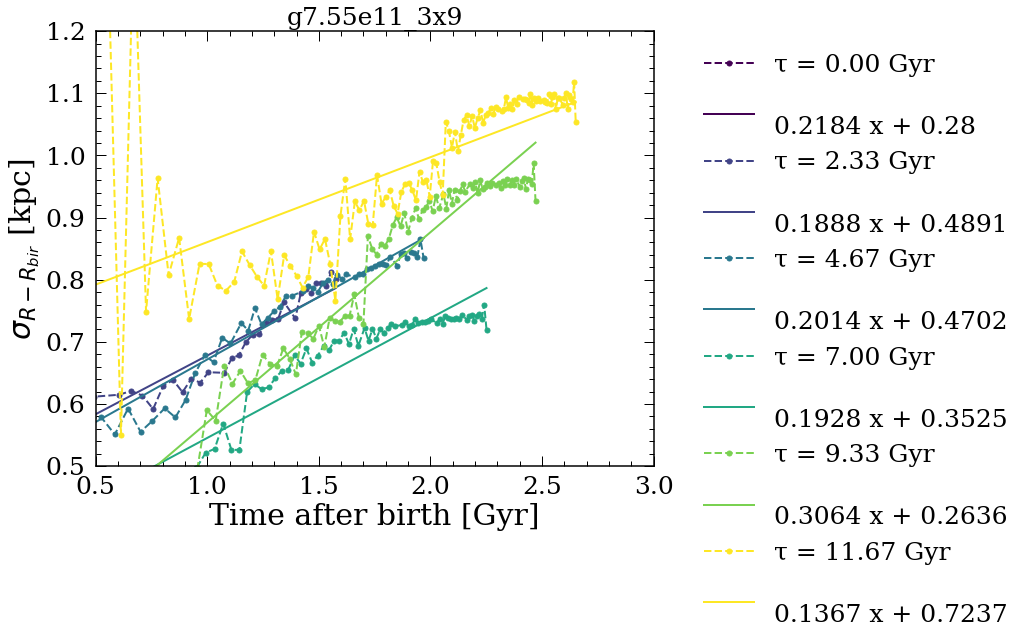

In [63]:
########################################
agebins = np.linspace(0,14,7)
whatagebin = np.nan*np.ones(len(agepickle))
for j in range(len(agebins)-1):
    m = ((agepickle['age']>agebins[j])&(agepickle['age']<agebins[j+1]))
    whatagebin[m] = j
agepickle['binNumb'] = whatagebin

alldrs = np.nan*np.ones((len(agebins)-1, len(allages_rs)))
for j in trange(len(allages_rs)):
    try:
        this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
        this_snap['age']
    except:
        print('no snap!')
        continue
    this_snap = pd.merge(this_snap[['iord','r']], agepickle[['iord','binNumb','Rbir']], 
                         left_on='iord', right_on='iord', how='inner')

    this_snap['dR'] = this_snap['r']-this_snap['Rbir']
    for k in this_snap['binNumb'].unique():
        m_eachbin = (this_snap['binNumb']==k)
        if sum(m_eachbin)==0:
            continue
        alldrs[int(k), j] = np.std(this_snap[m_eachbin]['dR'])
allcolors = getcolor(agebins)
plt.figure(figsize=(10,8))
for k in range(len(agebins)-1):
    PCM=plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), np.log(alldrs[k,:]), '--o',c=allcolors[k],markersize=5,
                 label='τ = %.2f Gyr'%agebins[k])
    m = (allages_rs-14.1+agebins[k]+2.5>1)
    p = fitpoints(np.log(allages_rs-14.1+agebins[k]+2.5)[m], np.log(alldrs[k,:])[m])
    plt.plot(np.log(allages_rs-14.1+agebins[k]+2.5), p(np.log(allages_rs-14.1+agebins[k]+2.5)), '-', c=allcolors[k], label=str(p))
plt.legend()
    
#cb.set_label('Age [Gyr]')
plt.xlabel('Time after birth [Gyr]')
plt.ylabel('$σ_{R-R_{bir}}$ [kpc]')
plt.title(sims[i], fontsize=25)
plt.legend(bbox_to_anchor=(1.05,1))
plt.ylim([0.5,1.2])
plt.xlim([0.5,3])

plt.legend(bbox_to_anchor=(1.05,1))
#plt.yscale('log')
        
        

# plot 100 stars near one radius and see the centering

In [21]:
i=0
Rbir_center = 7
Rbir_width = 0.5

simname = sims[i]
print(simname)
    
allsnaps = glob.glob(sims[i]+'/*.?????')

agepickle = readsimdata(simsnames[i],True, 15, 5)
agepickle = agepickle.loc[abs(agepickle['Rbir']-Rbir_center)<Rbir_width].reset_index(drop=True)

allsnaps_time = [int(i.split('.')[-1]) for i in allsnaps if (('param' not in i) and ('draco' not in i) and ('dat_' not in i) and ('79e12' not in i.split('.')[-1]))]
snaplookup = {int(allsnaps[i].split('.')[-1]):allsnaps[i] for i in range(len(allsnaps)) if (('param' not in allsnaps[i]) and ('draco' not in allsnaps[i]) and ('dat_' not in allsnaps[i]) and ('79e12' not in allsnaps[i].split('.')[-1]))}

sortage = sorted(allsnaps_time)
redshifts = np.zeros(len(sortage))
allages_rs = np.zeros(len(redshifts))

for j in trange(len(sortage)):
    s = pb.load(snaplookup[sortage[j]])
    h = s.properties['h']
    ages = float(str(s.properties['time']).split(' ')[0])
    allages_rs[j] = ages
    

g6.96e11_3x9


100%|██████████| 128/128 [00:15<00:00,  8.03it/s]


In [75]:
from os.path import exists

count = 0
enoughstar = 0
numbsSel = 1000

for j in trange(len(allages_rs)):
    if exists(snaplookup[sortage[j]]+'.pkl'):
        this_snap = pd.read_pickle(snaplookup[sortage[j]]+'.pkl')
        if len(this_snap)==0:
            print('no stars in this snap!')
            continue
        this_snap = pd.merge(this_snap, agepickle[['iord']], left_on='iord', right_on='iord',
                            how='inner')
        if len(this_snap)>=numbsSel: 
            count = 1
    else:
        print('no snap!')
        continue
    
    this_snap['r_'+str(sortage[j])] = this_snap['r']
    this_snap['x_'+str(sortage[j])] = this_snap['x']
    this_snap['y_'+str(sortage[j])] = this_snap['y']
    if count == 1 and enoughstar!=1:
        stars = this_snap[['iord','r_'+str(sortage[j]),
                               'x_'+str(sortage[j]),'y_'+str(sortage[j]), 'Rbir']]
        print('enough stars at snap'+str(sortage[j]))
        enoughstar = 1
        continue
    
    if enoughstar == 1:
        stars = pd.merge(stars, this_snap[['iord','r_'+str(sortage[j]),'x_'+str(sortage[j]),'y_'+str(sortage[j])]], left_on='iord', right_on='iord',
                         how='inner')
        
        
    
        

 18%|█▊        | 23/128 [00:00<00:00, 222.75it/s]

no snap!
no stars in this snap!
no stars in this snap!
no stars in this snap!
no stars in this snap!


 36%|███▌      | 46/128 [00:00<00:00, 158.14it/s]

enough stars at snap312


100%|██████████| 128/128 [00:04<00:00, 28.14it/s]


In [76]:

times = []
sigmars = []
sigmars_mean = []
for i in range(len(sortage)):
    try:
        stars['r_'+str(sortage[i])]
    except:
        #print('no radius!')
        continue
    times.append(allages_rs[i])
    sigmars.append(np.std(stars['r_'+str(sortage[i])]-stars['Rbir']))
    sigmars_mean.append(np.mean(stars['r_'+str(sortage[i])]-stars['Rbir']))
    
        

93 752 10.4 760 10.5


Text(0, 0.5, 'R [kpc]')

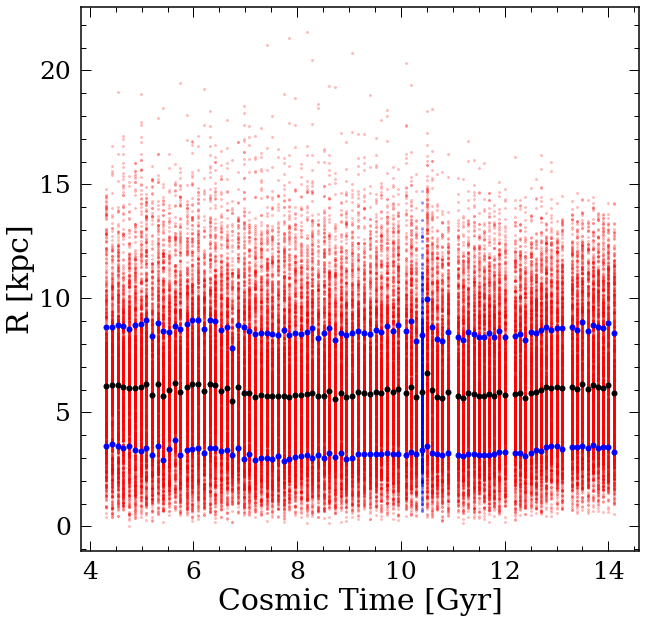

In [104]:

count = 0
colors = getcolor(allages_rs)
plt.figure()
for i in range(len(sortage)):
    try:
        stars['r_'+str(sortage[i])]
    except:
        #print('no radius!')
        continue
    count = count+1
    if count==56:
        print(i,sortage[i],allages_rs[i],sortage[i+1],allages_rs[i+1])
        plt.plot(allages_rs[i]*np.ones(len(stars['r_'+str(sortage[i])])), stars['r_'+str(sortage[i])], 
             'bo', markersize=2, alpha=0.2)
    else:
        plt.plot(allages_rs[i]*np.ones(len(stars['r_'+str(sortage[i])])), stars['r_'+str(sortage[i])], 
             'ro', markersize=2, alpha=0.2)
    plt.plot(allages_rs[i], np.mean(stars['r_'+str(sortage[i])]), 
             'ko', markersize=5, label='mean R')
    plt.plot(allages_rs[i], np.mean(stars['r_'+str(sortage[i])])-np.std(stars['r_'+str(sortage[i])]), 
             'bo', markersize=5, label='mean R')
    plt.plot(allages_rs[i], np.mean(stars['r_'+str(sortage[i])])+np.std(stars['r_'+str(sortage[i])]), 
             'bo', markersize=5, label='mean R')

plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('R [kpc]')
    
        

Text(0.5, 1.0, 'Cosmic Time:11.5')

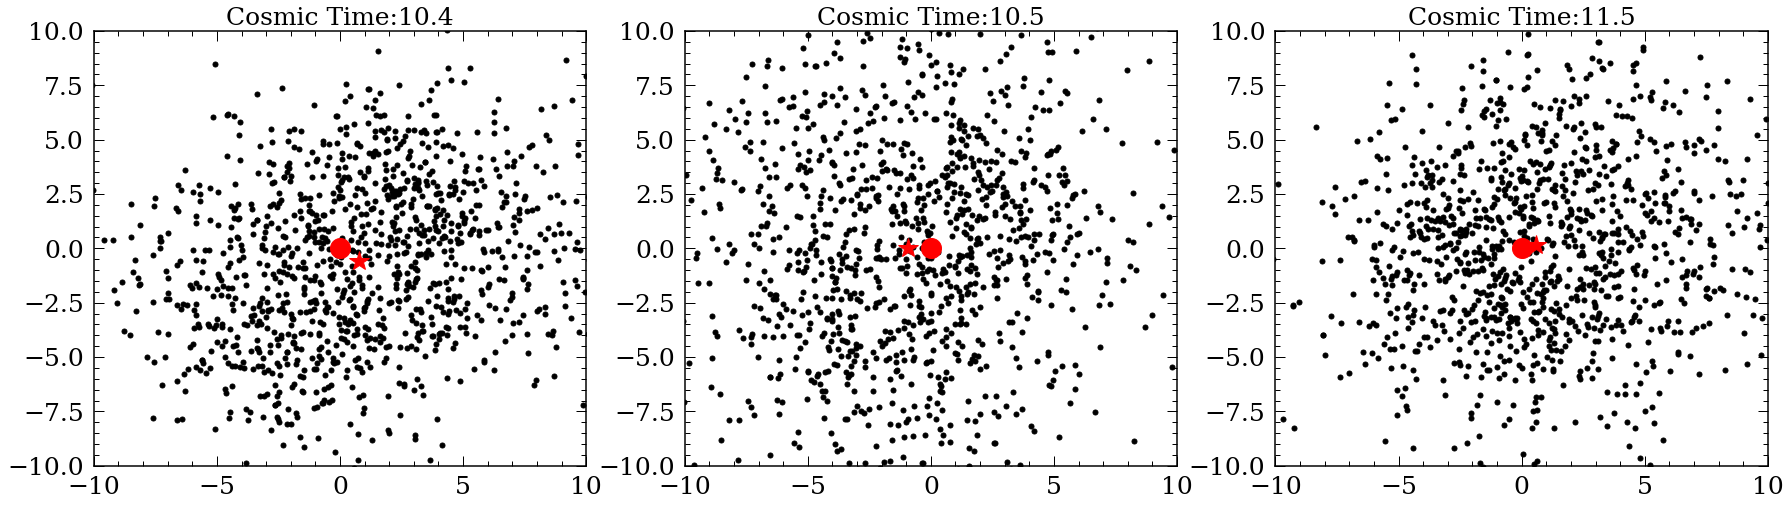

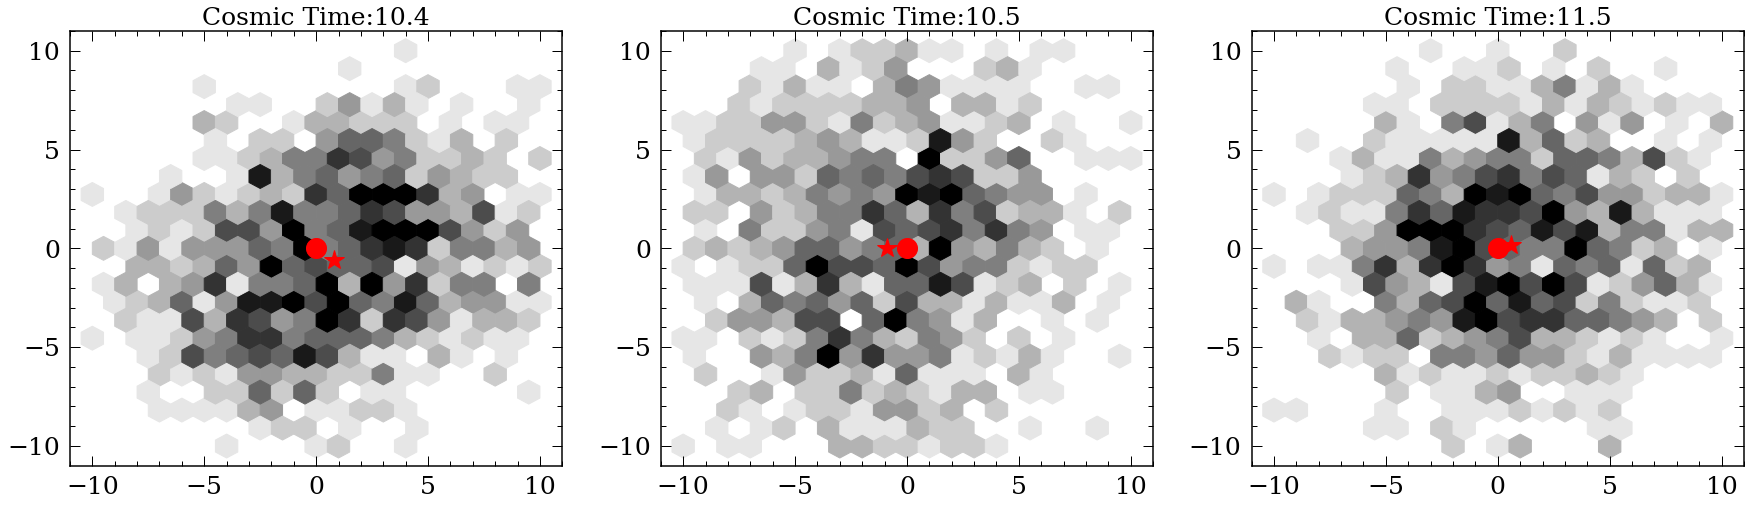

In [127]:

cmap = plt.cm.get_cmap('binary')
probsnap = 93


plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.plot(stars['x_'+str(sortage[probsnap])], stars['y_'+str(sortage[probsnap])], 'ko', markersize=5)
plt.plot(np.median(stars['x_'+str(sortage[probsnap])]), np.median(stars['y_'+str(sortage[probsnap])]),
        'r*', markersize=20)
plt.plot([0],[0],'ro',markersize=20)         
plt.title('Cosmic Time:'+str(allages_rs[probsnap]), fontsize=25)
plt.xlim([-10,10])
plt.ylim([-10,10])

plt.subplot(1,3,2)
plt.plot(stars['x_'+str(sortage[probsnap+1])], stars['y_'+str(sortage[probsnap+1])], 'ko', markersize=5)
plt.plot(np.median(stars['x_'+str(sortage[probsnap+1])]), np.median(stars['y_'+str(sortage[probsnap+1])]),
        'r*', markersize=20)
plt.plot([0],[0],'ro',markersize=20)
plt.title('Cosmic Time:'+str(allages_rs[probsnap+1]), fontsize=25)
plt.xlim([-10,10])
plt.ylim([-10,10])

plt.subplot(1,3,3)
plt.plot(stars['x_'+str(sortage[probsnap+10])], stars['y_'+str(sortage[probsnap+10])], 'ko', markersize=5)
plt.plot(np.median(stars['x_'+str(sortage[probsnap+10])]), np.median(stars['y_'+str(sortage[probsnap+10])]),
        'r*', markersize=20)
plt.plot([0],[0],'ro',markersize=20)
plt.title('Cosmic Time:'+str(allages_rs[probsnap+10]), fontsize=25)
plt.xlim([-10,10])
plt.ylim([-10,10])




plt.figure(figsize=(30,8))
plt.subplot(1,3,1)

#plt.plot(stars['x_'+str(sortage[probsnap])], stars['y_'+str(sortage[probsnap])], 'ro', markersize=5)
plt.plot(np.median(stars['x_'+str(sortage[probsnap])]), np.median(stars['y_'+str(sortage[probsnap])]),
        'r*', markersize=20)
plt.hexbin(stars['x_'+str(sortage[probsnap])], stars['y_'+str(sortage[probsnap])], extent=(-10,10,-10,10),
          mincnt=1,gridsize=20,cmap=cmap,vmin=0,vmax=10)
plt.plot([0],[0],'ro',markersize=20)         
plt.title('Cosmic Time:'+str(allages_rs[probsnap]), fontsize=25)

plt.subplot(1,3,2)
#plt.plot(stars['x_'+str(sortage[probsnap+1])], stars['y_'+str(sortage[probsnap+1])], 'ro', markersize=5)
plt.hexbin(stars['x_'+str(sortage[probsnap+1])], stars['y_'+str(sortage[probsnap+1])], extent=(-10,10,-10,10),
          mincnt=1,gridsize=20,cmap=cmap,vmin=0,vmax=10)
plt.plot(np.median(stars['x_'+str(sortage[probsnap+1])]), np.median(stars['y_'+str(sortage[probsnap+1])]),
        'r*', markersize=20)
plt.plot([0],[0],'ro',markersize=20)
plt.title('Cosmic Time:'+str(allages_rs[probsnap+1]), fontsize=25)

plt.subplot(1,3,3)
#plt.plot(stars['x_'+str(sortage[probsnap+10])], stars['y_'+str(sortage[probsnap+10])], 'ro', markersize=5)
plt.hexbin(stars['x_'+str(sortage[probsnap+10])], stars['y_'+str(sortage[probsnap+10])], extent=(-10,10,-10,10),
          mincnt=1,gridsize=20,cmap=cmap,vmin=0,vmax=10)
plt.plot(np.median(stars['x_'+str(sortage[probsnap+10])]), np.median(stars['y_'+str(sortage[probsnap+10])]),
        'r*', markersize=20)
plt.plot([0],[0],'ro',markersize=20)
plt.title('Cosmic Time:'+str(allages_rs[probsnap+10]), fontsize=25)


In [101]:
len(times), len(allages_rs)

(90, 128)

Text(0, 0.5, '$σ_{ΔR}$')

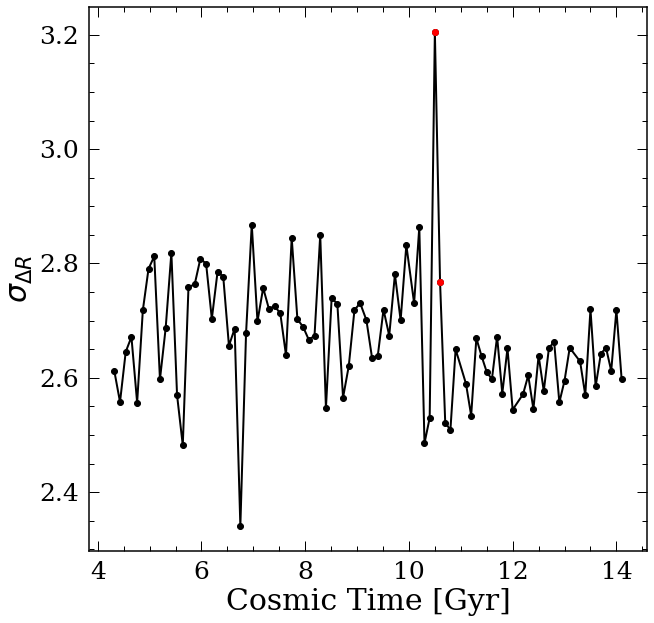

In [105]:
count = 56
times, sigmars = np.array(times, dtype=float), np.array(sigmars, dtype=float)
plt.plot(times, sigmars, 'k-o')
plt.plot(times[count], sigmars[count], 'ro')
plt.plot(times[count+1], sigmars[count+1], 'ro')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$σ_{ΔR}$')


Text(0, 0.5, '$mean_{ΔR}$')

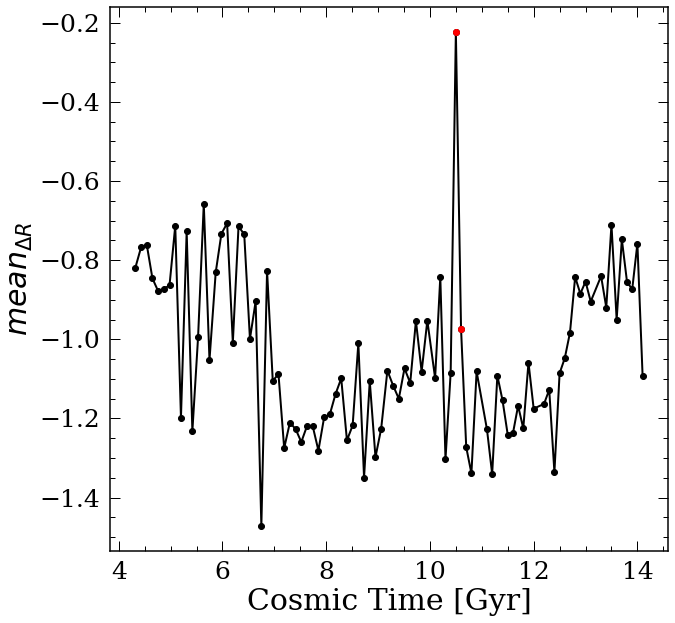

In [106]:

times, sigmars_mean = np.array(times, dtype=float), np.array(sigmars_mean, dtype=float)
plt.plot(times, sigmars_mean, 'k-o')
plt.plot(times[count], sigmars_mean[count], 'ro')
plt.plot(times[count+1], sigmars_mean[count+1], 'ro')
plt.xlabel('Cosmic Time [Gyr]')
plt.ylabel('$mean_{ΔR}$')



black: 3.2050408904842835
red: 2.768113681279977


Text(0.5, 0, '$R$-$R_{bir}$')

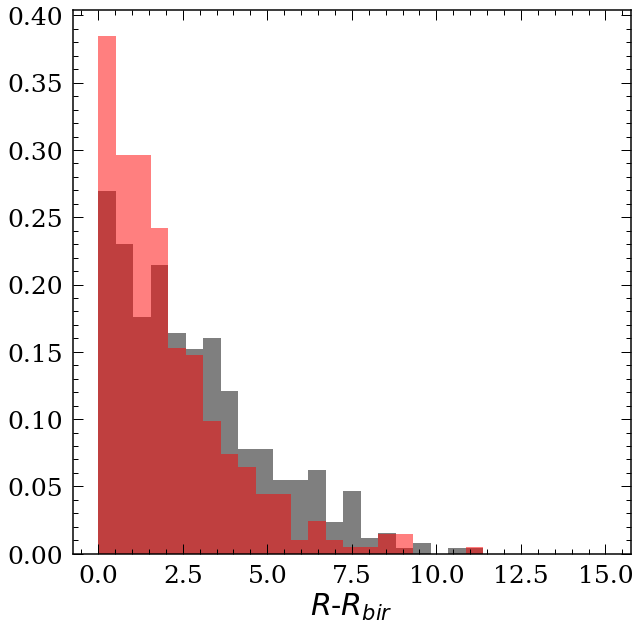

In [107]:

m = (allages_rs == times[count])
"""
plt.plot((stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir']), 
np.zeros(len(stars['r_'+str(np.array(sortage)[m][0])])), 
             'ro', markersize=2)
"""
plt.hist(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         density=True, color='k', bins=np.linspace(0,15,30),
        alpha=0.5);
print('black:', np.std((stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'])))

m = (allages_rs == times[count+1])
"""
plt.plot(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         np.zeros(len(stars['r_'+str(np.array(sortage)[m][0])])), 
             'ro', markersize=2)
"""
plt.hist(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir'], 
         density=True, color='r', bins=np.linspace(0,15,30),
        alpha=0.5);
print('red:', np.std(stars['r_'+str(np.array(sortage)[m][0])]-stars['Rbir']))
plt.xlabel('$R$-$R_{bir}$')
#plt.ylim([-0.2,0.55])

In [78]:
len(stars['r_'+str(np.array(sortage)[m][0])])

190

3.3668340260989043
3.059519878443134


Text(0.5, 0, 'R')

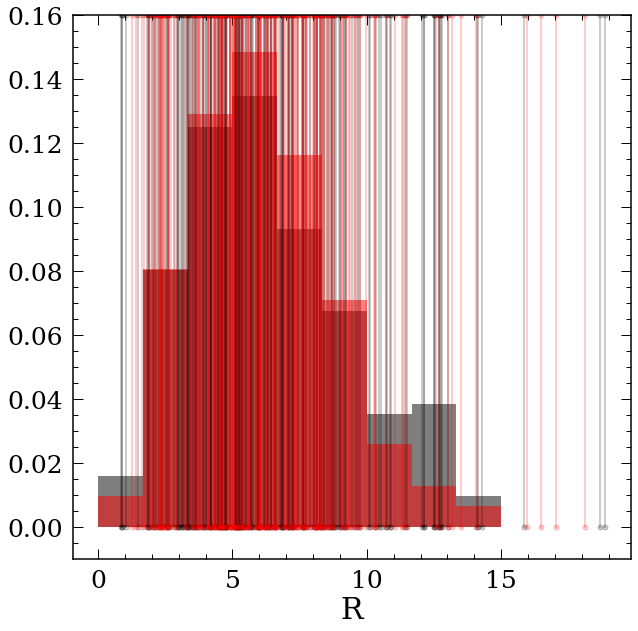

In [93]:

m = (allages_rs == times[100])

for i in range(len(stars['r_'+str(np.array(sortage)[m][0])])):
    plt.plot([(stars['r_'+str(np.array(sortage)[m][0])]).values[i],
              (stars['r_'+str(np.array(sortage)[m][0])]).values[i]], 
             [0,0.16], 'ko-', markersize=5, alpha=0.2)
plt.hist(stars['r_'+str(np.array(sortage)[m][0])], 
         density=True, color='k', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std((stars['r_'+str(np.array(sortage)[m][0])])))


m = (allages_rs == times[99])
for i in range(len(stars['r_'+str(np.array(sortage)[m][0])])):
    plt.plot([(stars['r_'+str(np.array(sortage)[m][0])]).values[i],
              (stars['r_'+str(np.array(sortage)[m][0])]).values[i]], 
             [0,0.16], 'ro-', markersize=5, alpha=0.2)
plt.hist(stars['r_'+str(np.array(sortage)[m][0])], 
         density=True, color='r', bins=np.linspace(0,15,10),
        alpha=0.5);
print(np.std(stars['r_'+str(np.array(sortage)[m][0])]))

plt.ylim([-0.01,0.16])
plt.xlabel('R')